# CS211: Data Privacy
## Final Project
### Nikhil and James

In [2]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import random
plt.style.use('seaborn-whitegrid')

# Preliminary utility functions
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def laplace_mech_vec(qs, sensitivity, epsilon):
    return [laplace_mech(q, sensitivity, epsilon) for q in qs]

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

# Database containing the default data of credit card clients Taiwan during 2005 
cc_default_db = pd.read_csv('https://raw.githubusercontent.com/nikhilchoppa/cs211-final-project/main/UCI_Credit_Card.csv')

/tmp/ipykernel_247788/1109455332.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
cc_default_db.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


### There are 25 variables in the `cc_default_db` Dataset:

- ID: ID of each client
- LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
- SEX: Gender (1=male, 2=female)
- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years
- PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
- PAY_2: Repayment status in August, 2005 (scale same as above)
- PAY_3: Repayment status in July, 2005 (scale same as above)
- PAY_4: Repayment status in June, 2005 (scale same as above)
- PAY_5: Repayment status in May, 2005 (scale same as above)
- PAY_6: Repayment status in April, 2005 (scale same as above)
- BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
- BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
- BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
- BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
- BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
- BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
- PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
- PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
- PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
- PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
- PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
- PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
- default.payment.next.month: Default payment (1=yes, 0=no)

## Generalize ages
A good first step to ensure privacy but only will satisfy k-anonimity, differential privacy will require additonal work 

In [11]:
# Generalizing the given column to essentially round to the nth decimal place
depths = {
    'AGE': 1
}

# Grabbed this part from HW2 / the textbook, applies the rounding described above to the given column(s) in the dataset
cc_default_db['AGE'] = cc_default_db[['AGE']].apply(lambda x: x.apply(lambda y: int(int(y/(10**depths[x.name]))*(10**depths[x.name]))))

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,20,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,20,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,30,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,30,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,50,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,30,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,40,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,30,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,40,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


## Differential Privacy
### Choosing a privacy budget
Defining the privacy budget in terms of epsilon $\epsilon$, keeping in mind that each row is an individual and allocating the budget in terms of the individual. The classic epsilon value of 1 should suffice for what we are doing here (EXPLAIN MORE).

In [17]:
epsilon = 0.1

### Adding Differential Privacy to `BILL_AMT, PAY_AMT`

In [15]:
# Applying the sparse vector technique to our differentially private statistics
# This will have to be done for each column in BILL_AMT1-6 and PAY_AMT1-6
# Takes a long time to run, but generates the correct b values!
def bill_and_pay_sum_and_average():
    # preserves epsilon-differential privacy
    def above_threshold(queries, df, T, epsilon):
        T_hat = T + np.random.laplace(loc=0, scale = 2/epsilon)   
        for idx, q in enumerate(queries):
            nu_i = np.random.laplace(loc=0, scale = 4/epsilon)
            if q(df) + nu_i >= T_hat:
                return idx
        # if the algorithm "fails", return a random index 
        # more convenient in certain use cases    
        return random.randint(0,len(queries)-1)
    
    dp_col_stats = {}
    for col in cc_default_db.columns:
        if 'BILL_AMT' in col or 'PAY_AMT' in col:
            df = cc_default_db[col]
            # Construct the stream of queries, the more the better even though this has a huge impact on runtime
            bs = range(1,150000,5)
            queries = [lambda df: df.clip(lower=0, upper=b).sum() - df.clip(lower=0, upper=b+1).sum() for b in bs]

            # Run AboveThreshold, using 1/3 of the privacy budget, to find a good clipping parameter
            epsilon_svt = epsilon / 3
            final_b = bs[above_threshold(queries, df, 0, epsilon_svt)]

            # Compute the noisy sum and noisy count, using 1/3 of the privacy budget for each
            epsilon_sum = epsilon / 3
            epsilon_count = epsilon / 3

            noisy_sum = laplace_mech(df.clip(lower=0, upper=final_b).sum(), final_b, epsilon_sum)
            noisy_count = laplace_mech(len(df), 1, epsilon_count)
            noisy_average = noisy_sum / noisy_count

            # Add those statistics to the respective column
            dp_col_stats[col] = [noisy_sum, noisy_average]
            
    return dp_col_stats

# Just use classic DP for counts of other columns
# Using the lambda function to preserve the pandas data frame
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon)

def limit_bal_counts():
    return cc_default_db['LIMIT_BAL'].value_counts().apply(f)

def sex_counts():
    return cc_default_db['SEX'].value_counts().apply(f)

def education_counts():
    return cc_default_db['EDUCATION'].value_counts().apply(f)
    
def marriage_counts():
    return cc_default_db['MARRIAGE'].value_counts().apply(f)
    
def age_counts():
    return cc_default_db['AGE'].value_counts().apply(f)

def pay_counts():
    counts = {}
    for i in range(1,7):
        col = 'PAY_' + str(i)
        counts[col] = cc_default_db[col].value_counts().apply(f)
    return counts

## Calculating non DP statistics
In order to compare and show how adding noise affects the queries

In [8]:
# Counting queries for every row
col_counts = {}
for col in cc_default_db.columns:
    if col != 'ID': # Skip the ID column for obvious reasons
        col_counts[col] = cc_default_db[col].value_counts()
        
col_sums = {}
for col in cc_default_db.columns:
    if col != 'ID':
        col_sums[col] = cc_default_db[col].sum()

col_averages = {}
for col in cc_default_db.columns:
    if col != 'ID':
        col_averages[col] = cc_default_db[col].mean()

## Format data to not be so clunky
### ...Merge all the columns that have `"_#"`
This is just signifying month to month data and it is going to be easier to work with if they are centralized to one column for PAY, BILL_AMT,and PAY_AMT

In [7]:
# Generate column names
merge_cols = []
for comb_col in ['PAY', 'BILL_AMT', 'PAY_AMT']:
    comb_row = []
    for i in range(1,7):
        if comb_col == 'PAY':
            comb_row.append(comb_col + '_' + str(i))
        else:
            comb_row.append(comb_col + str(i))
    merge_cols.append(comb_row)

In [8]:
fresh_cols = []
for col in merge_cols:
    new_row = []
    for row in range(len(cc_default_db)):
        new_col = []
        for sub_col in col:
            new_col.append(cc_default_db[sub_col][row])
        new_row.append(new_col)
    fresh_cols.append(new_row)

In [9]:
# Apply what we did above
for subcol in merge_cols:
    for c in subcol:
        cc_default_db.drop(c, axis=1, inplace=True)
cc_default_db['PAY'], cc_default_db['BILL_AMT'], cc_default_db['PAY_AMT'] = [fresh_cols[0], fresh_cols[1], fresh_cols[2]]

## Comparing Differentially Private and non DP statistics
This will involve looking at the differences in the histograms for the LIMIT_BAL and AGE columns. While the percent error will be contrasted between the BAL_AMT and PAY_AMT statistics. 

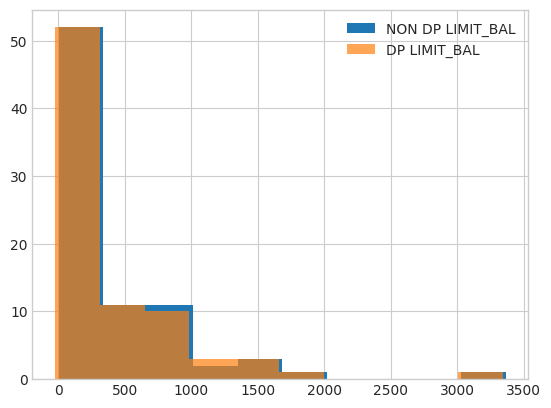

In [38]:
# plot non DP LIMIT_BAL
plt.hist(col_counts['LIMIT_BAL'], label='NON DP LIMIT_BAL');
# plot DP LIMIT_BAL
plt.hist(limit_bal_counts(), alpha=.7, label='DP LIMIT_BAL');
plt.legend();

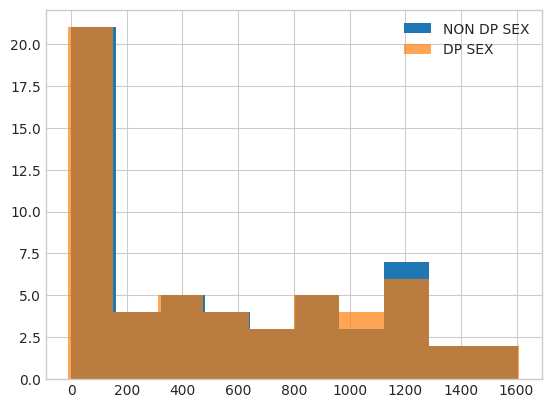

In [56]:
# plot non DP LIMIT_BAL
plt.hist(col_counts['AGE'], label='NON DP SEX');
# plot DP LIMIT_BAL
plt.hist(age_counts(), alpha=.7, label='DP SEX');
plt.legend();

In [61]:
dp_sums_and_averages = bill_and_pay_sum_and_average()

50.707551178112865
50.535610577015554
32.69107597283521
32.68832846611872
17.288930379372992
17.42906140277414
66.09702973344237
66.0481056669752
34.96845895232673
34.860377120614
22.439427354212317
22.43244064027583


In [66]:
print(pct_error(col_sums['BILL_AMT1'], dp_sums_and_averages['BILL_AMT1'][0]))
print(pct_error(col_averages['BILL_AMT1'], dp_sums_and_averages['BILL_AMT1'][1]))

print(pct_error(col_sums['BILL_AMT2'], dp_sums_and_averages['BILL_AMT2'][0]))
print(pct_error(col_averages['BILL_AMT2'], dp_sums_and_averages['BILL_AMT2'][1]))

print(pct_error(col_sums['BILL_AMT3'], dp_sums_and_averages['BILL_AMT3'][0]))
print(pct_error(col_averages['BILL_AMT3'], dp_sums_and_averages['BILL_AMT3'][1]))

print(pct_error(col_sums['BILL_AMT4'], dp_sums_and_averages['BILL_AMT4'][0]))
print(pct_error(col_averages['BILL_AMT4'], dp_sums_and_averages['BILL_AMT4'][1]))

print(pct_error(col_sums['BILL_AMT5'], dp_sums_and_averages['BILL_AMT5'][0]))
print(pct_error(col_averages['BILL_AMT5'], dp_sums_and_averages['BILL_AMT5'][1]))

print(pct_error(col_sums['BILL_AMT6'], dp_sums_and_averages['BILL_AMT6'][0]))
print(pct_error(col_averages['BILL_AMT6'], dp_sums_and_averages['BILL_AMT6'][1]))



print(pct_error(col_sums['PAY_AMT1'], dp_sums_and_averages['PAY_AMT1'][0]))
print(pct_error(col_averages['PAY_AMT1'], dp_sums_and_averages['PAY_AMT1'][1]))

print(pct_error(col_sums['PAY_AMT2'], dp_sums_and_averages['PAY_AMT2'][0]))
print(pct_error(col_averages['PAY_AMT2'], dp_sums_and_averages['PAY_AMT2'][1]))

print(pct_error(col_sums['PAY_AMT3'], dp_sums_and_averages['PAY_AMT3'][0]))
print(pct_error(col_averages['PAY_AMT3'], dp_sums_and_averages['PAY_AMT3'][1]))

print(pct_error(col_sums['PAY_AMT4'], dp_sums_and_averages['PAY_AMT4'][0]))
print(pct_error(col_averages['PAY_AMT4'], dp_sums_and_averages['PAY_AMT4'][1]))

print(pct_error(col_sums['PAY_AMT5'], dp_sums_and_averages['PAY_AMT5'][0]))
print(pct_error(col_averages['PAY_AMT5'], dp_sums_and_averages['PAY_AMT5'][1]))

print(pct_error(col_sums['PAY_AMT6'], dp_sums_and_averages['PAY_AMT6'][0]))
print(pct_error(col_averages['PAY_AMT6'], dp_sums_and_averages['PAY_AMT6'][1]))

50.707551178112865
50.535610577015554
32.69107597283521
32.68832846611872
17.288930379372992
17.42906140277414
66.09702973344237
66.0481056669752
34.96845895232673
34.860377120614
22.439427354212317
22.43244064027583
99.47840551328325
99.47853416667914
99.98614360185867
99.98614534458336
98.39094871991928
98.39189899162638
99.4982143127509
99.4984341529324
99.90302089372568
99.9032295819207
156465077.0 363048.2426771958
99.76799525012564


## Generate the PDF writeup document

In [ ]:
from pylatex import Document, Section, Subsection, Command, Math, NoEscape, MediumText, Subsubsection
from pylatex.utils import italic, NoEscape, verbatim

doc = Document()

doc.preamble.append(Command('title', 'Credit Card Clients Data Report'))
doc.preamble.append(Command('date', NoEscape(r'\today')))
doc.append(NoEscape(r'\maketitle'))

epsilon_eq = NoEscape(r'$\epsilon$=')

doc.append('All data labeled "differentially private" in this document satisfies differential privacy for ')
doc.append(epsilon_eq)
doc.append(f'{epsilon} by sequential composition')

with doc.create(Section('Statistics')):

    with doc.create(Subsection('Basic Averages')):
        doc.append('The follwing statistics were all generated using the sparse vector technique to determine a clipping parameter for the data, and then generating differentially private sums and counts to find a differentially private average.')
        with doc.create(Subsubsection('Average Age')):
            doc.append(f'The average age of all credit card customers is {round(dp_age_avg[1], 2)}, the differentially private average age of all customers is {round(dp_age_avg[0], 2)}. This gives an error of {round(dp_age_avg[2], 4)}%.')
        with doc.create(Subsubsection('Average Credit Limit Balance')):
            doc.append(f'The average credit card balance limit of all credit card customers is {round(dp_limit_bal_avg[1], 2)}, the differentially private average age of all customers is {round(dp_limit_bal_avg[0], 2)}. This gives an error of {round(dp_limit_bal_avg[2], 4)}%.')
        with doc.create(Subsubsection('Average Bill Amount')):
            doc.append(f'The average bill amount of all credit card customers is {round(dp_bill_amt_avg[1], 2)}, the differentially private average age of all customers is {round(dp_bill_amt_avg[0], 2)}. This gives an error of {round(dp_bill_amt_avg[2], 4)}%.')
        with doc.create(Subsubsection('Average Pay Amount')):
            doc.append(f'The average pay amount of all credit card customers is {round(dp_pay_amt_avg[1], 2)}, the differentially private average age of all customers is {round(dp_pay_amt_avg[0], 2)}. This gives an error of {round(dp_pay_amt_avg[2], 4)}%.')     
        
    with doc.create(Subsection('Basic Counts')):
        doc.append('The follwing statistics were all generated using the report noisy max method to determine the highest count in a given parameter.')
        with doc.create(Subsubsection('Bill Amount Categories')):
            doc.append(f'The most common bill amount category of all credit card customers is {dp_bill_amt_count[1]}. The most common income category as determined by using a differentially private method is {dp_bil_amt_count[0]}.')
        with doc.create(Subsubsection('Education Level Categories')):
            doc.append(f'The most common education level of all credit card customers is {dp_education_count[1]}. The most common education level as determined by using a differentially private method is {dp_education_count[0]}.')
    
    with doc.create(Subsection('Conditional Averages')):
        with doc.create(Subsubsection('Average Credit Limit Balance for Customers 33 years old and younger.')):
            doc.append(f'The average credit limit balance of credit card customers who are 33 years old and younger is {round(dp_limit_bal_less_33[1], 2)}, the differentially private average is {round(dp_limit_bal_less_33[0], 2)}. This gives an error of {round(dp_limit_bal_less_33[2], 4)}%.')
        with doc.create(Subsubsection('Average Credit Limit Balance for Customers older than 33 years old.')):
            doc.append(f'The average credit limit balance of credit card customers who are over 33 years old is {round(dp_limit_bal_over_33[1], 2)}, the differentially private average is {round(dp_limit_bal_over_33[0], 2)}. This gives an error of {round(dp_limit_bal_over_33[2], 4)}%.')
    
    with doc.create(Subsection('Conditional Counts')):
        with doc.create(Subsubsection('Most Common Income Category for College Educated Customers')):
            doc.append(f'The most common income level for college educated customers is {dp_income_education_count[1]}, the most common one calculated with a differentially private method is {dp_income_education_count[0]}. ')
        with doc.create(Subsubsection('Most Common Income Category for non College Educated Customers')):
            doc.append(f'The most common income level for non college educated customers is {dp_income_no_education_count[1]}, the most common one calculated with a differentially private method is {dp_income_no_education_count[0]}. ')

            

doc.generate_pdf('final_report', clean_tex=False)

tex = doc.dumps()
out = open("fianl_report.pdf", "a")
out.write(pdf)
out.close()